## Snakemake for Converting GMET Forcing to Snakemake ##

Initial workflow file to test capabilities of [snakemake](https://snakemake.readthedocs.io/en/stable/).



In [3]:
%%writefile ../gmet_to_summa.smk
''' 
gmet to summa snakemake master snakemake file

This snakemake file runs all the steps required to convert GMET forcings to SUMMA forcings.

Original process code: Andy Wood
Adapted to Snakemake: Dave Casson

'''
from pathlib import Path
from scripts import gmet_to_summa_utils as utils

# Resolve paths from the configuration file
config = utils.resolve_paths(config, log_config = True)

# Read in all local snakemake files and rules
include: './rules/gmet_file_prep.smk'
include: './rules/remap_gmet_to_shp.smk'
include: './rules/metsim_file_prep.smk'
include: './rules/run_metsim.smk'
include: './rules/metsim_to_summa.smk'

# Read all forcing files and create a list based on the output directory (i.e. ens/filename.nc)
_, file_path_list = utils.build_ensemble_list(config['gmet_forcing_dir'])

# Run the snakemake file, so that that it produces a summa input file for each of the gmet forcing files
rule gmet_to_summa:
    input:
        expand(Path(config['summa_forcing_dir'],'{forcing_file}.nc'), forcing_file = file_path_list)
        

Overwriting ../gmet_to_summa.smk


### Perform a Dry Run, and unlock the working directory

In [ ]:
## Perform a dry run to check the workflow is configured correctly.
! snakemake --unlock -s ../gmet_to_summa.smk --configfile ../config/gmet_to_summa_test_case_config.yaml
! snakemake -s ../gmet_to_summa.smk --configfile ../config/gmet_to_summa_test_case_config.yaml --dry-run

## Run the complete gmet to summa snakemake workflow

In [ ]:
! snakemake -s ../gmet_to_summa.smk -c 8 --configfile ../config/gmet_to_summa_test_case_config.yaml

In [ ]:
### Visualize the workflow

Settings logged from {'base_settings': {'case_name': 'test_case'}, 'key_directories': {'gmet_forcing_dir': '../../test_data/gmet/', 'working_dir': '../../test_data/working_dir/', 'summa_dir': '../../test_data/summa/', 'summa_forcing_dir': '../../test_data/summa/forcing/'}, 'input_files': {'catchment_shp': '../../test_data/shp/tuolumne_elev_band.gpkg', 'attribute_nc': '../../test_data/summa/attributes.nc', 'metsim_base_config': '../config/metsim_base_config.yaml'}, 'easymore': {'catchment_shp_hru_id_field': 'HRU_ID', 'catchment_shp_lat_id_field': 'latitude', 'catchment_shp_lon_id_field': 'longitude', 'forcing_shp': 'forcing_shp.shp'}, 'metsim': {'metsim_timestep_minutes': 60, 'metsim_domain_nc': 'domain.nc', 'out_freq': 'Y'}, 'gmet': {'gmet_input_var': ['pcp', 't_max', 't_min']}}
Building DAG of jobs...


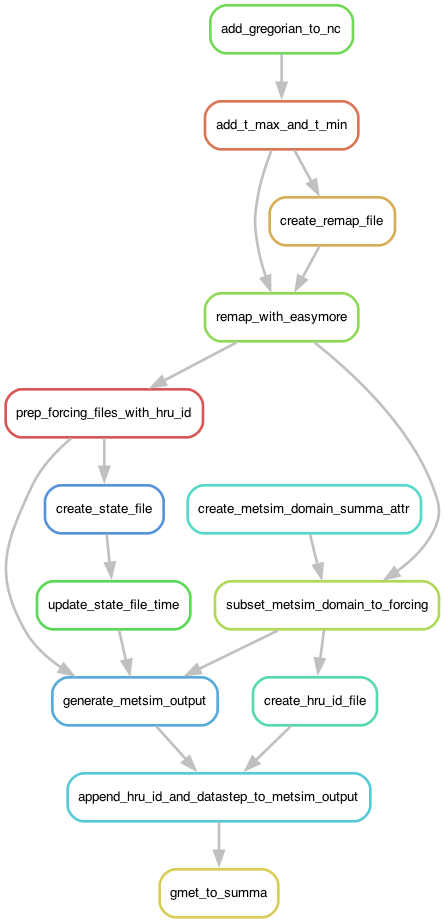

In [70]:
from IPython import display
# Buold build the rule graph
! snakemake -s ../gmet_to_summa.smk --configfile ../config/gmet_to_summa_test_case_config.yaml --rulegraph | dot -Tpng > ../reports/gmet_to_summa.png

# Build the file graph
! snakemake -s ../gmet_to_summa.smk --configfile ../config/gmet_to_summa_test_case_config.yaml --filegraph | dot -Tpng > ../reports/gmet_to_summa.png

# Python command to visualise the built image in our notebook
display.Image('../reports/gmet_to_summa.png')

In [2]:
! snakemake -s ../gmet_to_summa.smk --configfile ../config/gmet_to_summa_test_case_config.yaml --gui


Settings logged from {}
KeyError in file /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/gmet_to_summa.smk, line 14:
'working_dir'
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/gmet_to_summa.smk", line 14, in <module>
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/scripts/gmet_to_summa_utils.py", line 28, in resolve_paths
Settings logged from {}
KeyError in file /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/gmet_to_summa.smk, line 14:
'working_dir'
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/gmet_to_summa.smk", line 14, in <module>
  File "/Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/scripts/gmet_to_summa_utils.py", line 28, in resolve_paths
Listening on http://127.0.0.1:8000.
Open this address in your browser to access the GUI.
 * Serving Flask app 'snakemake'
 * Debug mode: off
Settings logged from {}
KeyError in file /Users/drc858/GitHub/gmet_to_summa_snakemake/workflow/gmet_to_summa.smk, line 14:
'working_dir'
